In [17]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
mt5.initialize()
import ta

In [18]:
# INITIALIZE THE DEVICE
mt5.initialize()

# Create empty lists
symbols = []
sectors = []
descriptions = []

# Get the information for all symbol
symbols_information = mt5.symbols_get()

# Tuple to list
symbols_information_list = list(symbols_information)

# Extract the name of the symbol
for element in symbols_information_list:
    symbols.append(list(element)[-3])
    sectors.append(list(element)[-1].split("\\")[0])
    descriptions.append(list(element)[-7])

# Create a dataframe
informations = pd.DataFrame([symbols, sectors, descriptions], index=["Symbol", "Sector", "Description"]).transpose()

informations

,Symbol,Sector,Description
0,ABEVA207,BMF,"ABEVE ON 20,25"
1,ABEVA212,BMF,"ABEVE ON 20,75"
2,ABEVA216,BMF,"ABEVE ON 21,25"
3,ABEVA219,BMF,"ABEV ON 21,50"
4,ABEVA221,BMF,"ABEVE ON 21,75"
...,...,...,...
69941,SBSPN345,BOVESPA,"SBSPE ON 34,50"
69942,SBSPN365,BOVESPA,"SBSPE ON 36,50"
69943,SBSPN375,BOVESPA,"SBSPE ON 37,50"
69944,SBSPN385,BOVESPA,"SBSPE ON 38,50"


In [19]:
# Create empty list
spread = []

# Computze the spread
for symbol in informations["Symbol"]:
    try:
        ask =  mt5.symbol_info_tick(symbol).ask
        bid =  mt5.symbol_info_tick(symbol).bid
        spread.append((ask - bid) / bid )

    except:
        spread.append(None)

# Take the assets with the spread < 0.07%
informations["Spread"] = spread
lowest_spread_asset = informations.dropna().loc[informations["Spread"]<0.0035]

informations

,Symbol,Sector,Description,Spread
0,ABEVA207,BMF,"ABEVE ON 20,25",NaN
1,ABEVA212,BMF,"ABEVE ON 20,75",NaN
2,ABEVA216,BMF,"ABEVE ON 21,25",NaN
3,ABEVA219,BMF,"ABEV ON 21,50",NaN
4,ABEVA221,BMF,"ABEVE ON 21,75",NaN
...,...,...,...,...
69941,SBSPN345,BOVESPA,"SBSPE ON 34,50",NaN
69942,SBSPN365,BOVESPA,"SBSPE ON 36,50",NaN
69943,SBSPN375,BOVESPA,"SBSPE ON 37,50",NaN
69944,SBSPN385,BOVESPA,"SBSPE ON 38,50",NaN


In [20]:
def get_data(symbol, n, timeframe=mt5.TIMEFRAME_D1):
    """ Function which returns the data of the symbol"""

    # Initialize MetaTrader device
    mt5.initialize()

    # Put the data in a dataframe
    utc_from = datetime.now()+timedelta(hours=2)
    rates = mt5.copy_rates_from(symbol, timeframe, utc_from,n)
    rates_frame = pd.DataFrame(rates)

    # Convert time in seconds into the datetime format
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame['time'] =  pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')
    rates_frame = rates_frame.set_index('time')

    return rates_frame

In [21]:
def features_engineering(df):
    """ This function which creates all the necessary sets for the algorithms"""

    # Allows the variables to be call outside the function
    global X_train
    global X_test
    global y_train_reg
    global y_train_cla
    global X_train_scaled
    global X_test_scaled
    global split_train_test
    global split_test_valid
    global X_valid
    global X_valid_scaled
    global X_train_pca
    global X_test_pca
    global X_val_pca


    # Create ours own metrics to compute the strategy returns
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"]).shift(1)
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1)).shift(1)
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1)).shift(1)


    # Features engineering
    df["returns t-1"] = df[["returns"]].shift(1)

    # Mean of returns
    df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
    df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

    # Volatility of returns
    df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
    df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

    # Drop missing values
    df = df.dropna()

    # Percentage train set
    split = int(0.80*len(df))



    list_x = ["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]


    split_train_test = int(0.70*len(df))
    split_test_valid = int(0.90*len(df))

    # Train set creation
    X_train = df[list_x].iloc[:split_train_test]

    y_train_reg = df[["returns"]].iloc[:split_train_test]

    y_train_cla = np.round(df[["returns"]].iloc[:split_train_test]+0.5)


    # Test set creation
    X_test = df[list_x].iloc[split_train_test:split_test_valid]

    # Test set creation
    X_val = df[list_x].iloc[split_test_valid:]


    # NORMALIZATION
    # Import the class
    from sklearn.preprocessing import StandardScaler

    # Initialize the class
    sc = StandardScaler()

    # Standardize the data
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    X_val_scaled = sc.transform(X_val)





    # PCA
    # Import the class
    from sklearn.decomposition import PCA

    # Initiliaze the class
    pca = PCA(n_components=3)

    # Apply the PCA
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    X_val_pca = pca.transform(X_val_scaled)

In [22]:
def predictor(df, model, reg=True, spread = 0.035):
    model.fit(X_train_pca, y_train_cla)


    df = df.dropna()
    # Create predictions for the whole dataset
    df["prediction"] = model.predict(np.concatenate((X_train_pca,X_test_pca, X_val_pca),
                                                    axis=0))

    if reg==False:
        df["prediction"] = np.where(df["prediction"]==0, -1, 1)

    df["prediction"] = df.prediction
    df=df.dropna()
    # Compute the strategy
    df["strategy"] = df["prediction"]* df["returns"]

    returns = df["strategy"].iloc[split_train_test:split_test_valid]

    return np.sqrt(252) * (returns.mean()-(spread/100))/ returns.std()

In [23]:

# Import the class
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
# Models
tree = DecisionTreeClassifier(max_depth=6)
svr = SVC(C=1.5)
lin = LogisticRegression()


# Initialization
symbols = lowest_spread_asset["Symbol"]
lists = []
lenght = []
mt5.initialize()
for symbol in tqdm(symbols):

    try:
        df = get_data(symbol, 3500).dropna()

        df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)


        features_engineering(df)


        """ Decision tree rgressor"""
        sharpe_tree = predictor(df, tree, reg=True)
        lists.append([symbol, "Tree", sharpe_tree, len(df)])

        """ SVR """
        sharpe_svr = predictor(df, svr, reg=False)
        lists.append([symbol, "SVR", sharpe_svr, len(df)])

        """ Linear Regression"""
        sharpe_linreg = predictor(df, lin, reg=False)
        lists.append([symbol, "LinReg", sharpe_linreg, len(df)])
    except:
        print("Issue during the importation of the data")

  1%|          | 1/81 [00:00<00:08,  9.90it/s]

Issue during the importation of the data
Issue during the importation of the data


  4%|▎         | 3/81 [00:00<00:07, 10.52it/s]

Issue during the importation of the data
Issue during the importation of the data
Issue during the importation of the data

  6%|▌         | 5/81 [00:00<00:06, 10.93it/s]

100%|██████████| 81/81 [00:44<00:00,  1.81it/s]


In [24]:
results = pd.DataFrame(lists, columns=["Symbol", "Model", "Sharpe", "Lenght"])
results.sort_values(by="Sharpe", ascending=False).loc[results["Lenght"]>600].head(35)

,Symbol,Model,Sharpe,Lenght
200,CRFB3,LinReg,2.586771,1066
210,GNDI3,Tree,2.441947,881
179,VIVT3,LinReg,1.814905,2497
224,TIMS3,LinReg,1.589760,2499
50,CVCB3,LinReg,1.589472,1944
197,AZUL4,LinReg,1.276377,1134
147,RADL3,Tree,1.222567,2569
199,CRFB3,SVR,1.217150,1066
145,QUAL3,SVR,1.208377,2554
68,ENBR3,LinReg,1.190087,2619


In [25]:
def voting(df, reg=True):
    """ Create a strategy using a voting method"""
    # Import the class


    # Import the models
    if reg:
        tree = DecisionTreeRegressor(max_depth=6)
        svr = SVR(epsilon=1.5)
        lin = LinearRegression()
        vot = VotingRegressor(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])
    else:
        tree = DecisionTreeClassifier(max_depth=6)
        svr = SVC()
        lin = LogisticRegression()

        vot = VotingClassifier(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])

    # Train the model
    if reg==False:
        vot.fit(X_train_pca, y_train_cla)
    else:
        vot.fit(X_train_pca, y_train_reg)

    # Remove missing values
    df = df.dropna()

    # Create predictions for the whole dataset
    df["prediction"] = vot.predict(np.concatenate((X_train_pca,
                                                   X_test_pca,
                                                   X_val_pca),
                                                  axis=0))

    # Remove missing values
    df = df.dropna()

    if reg==False:
        df["prediction"] = np.where(df["prediction"]==0, -1, 1)

    # Compute the strategy
    df["strategy"] = np.sign(df["prediction"]) * df["returns"]
    df["low_strategy"] = np.where(df["prediction"]>0, df["sLow"], -df["sHigh"])
    df["high_strategy"] = np.where(df["prediction"]>0, df["sHigh"], -df["sLow"])


    return vot, df["strategy"], df["low_strategy"], df["high_strategy"]

In [26]:
mt5.initialize()

# Import the class
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.ensemble import VotingRegressor, VotingClassifier
import pickle
from joblib import dump, load

# Initialization
lists = []
res = pd.DataFrame()
low_assets = pd.DataFrame()
high_assets = pd.DataFrame()

for symbol in ["CRFB3", "GNDI3", "VIVT3", "CVCB3", "RADL3","AZUL4", "QUAL3", "ENBR3", "CSAN3"]:
    print(symbol)


    # Import the data
    df = get_data(symbol, 3500).dropna()

    # Create ours own metrics to compute the strategy returns
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"]).shift(1)
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1)).shift(1)
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1)).shift(1)
    # Remove missing values
    df = df.dropna()

    # Create the sets
    features_engineering(df)

    # Compute the strategy
    vot, res[symbol],low_assets[symbol],high_assets[symbol] = voting(df, reg=False)

    # Save the model
    s = pickle.dumps(vot)
    alg = pickle.loads(s)

    #dump(alg ,f"Models/{symbol}_voting.joblib")

CRFB3
GNDI3
VIVT3
CVCB3
RADL3
AZUL4
QUAL3
ENBR3
CSAN3


<AxesSubplot:xlabel='time'>

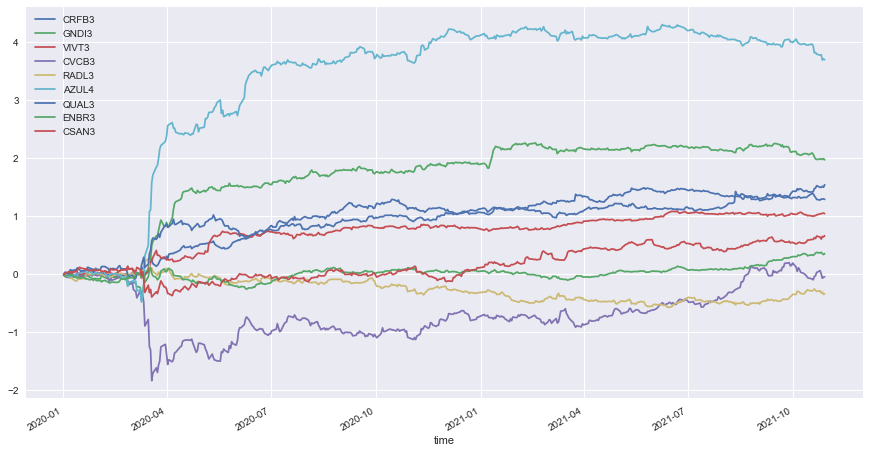

In [27]:
# Display cumulative returns of the strategies on the test set
data = res.dropna().loc["2020-01":"2021-10"]
data.cumsum().plot(figsize=(15,8))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.25684835164824904
            Iterations: 15
            Function evaluations: 150
            Gradient evaluations: 15
[0.087 0.288 0.    0.    0.    0.625 0.    0.    0.   ]
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: -0.186 	 Alpha: -13.41 %	     Sharpe: -0.59 	 Sortino: -0.865
  -----------------------------------------------------------------------------
    VaR: 106.78 %	 cVaR: 119.2 % 	     VaR/cVaR: 1.116 	 drawdown: 40.31 %
  -----------------------------------------------------------------------------


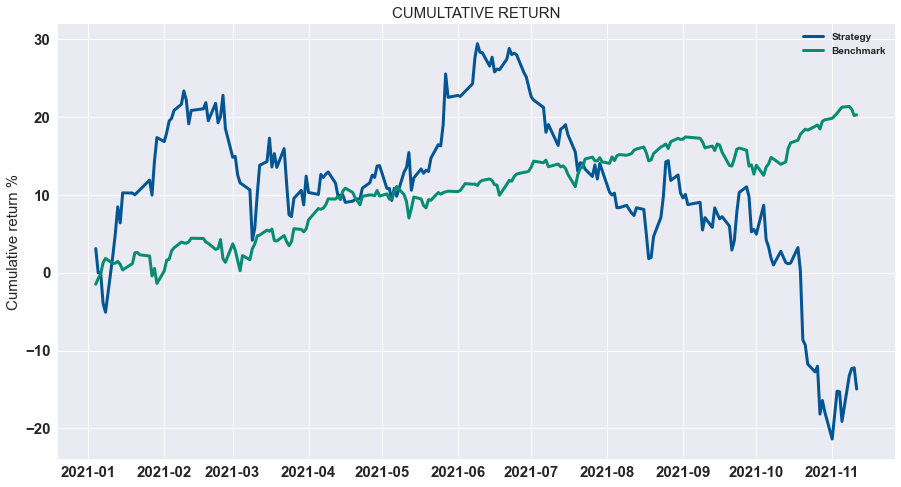

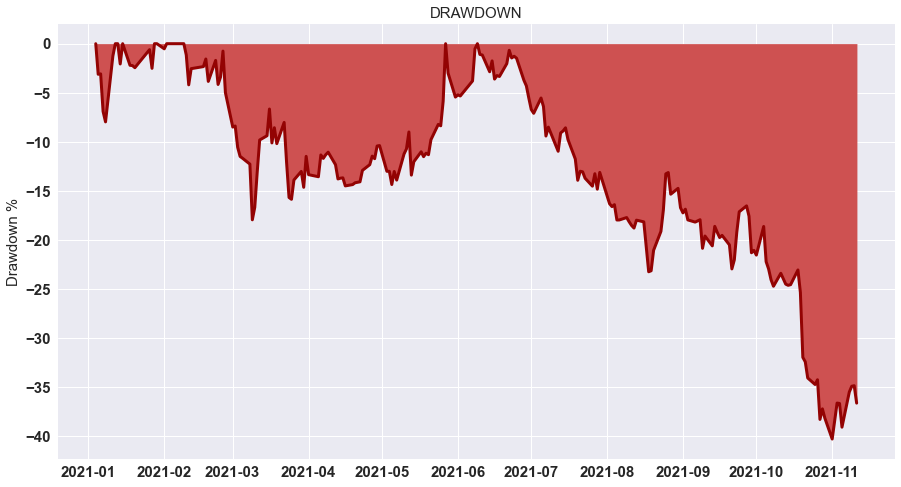

In [29]:
from quantreo.portfolio import *
data = res.dropna().loc["2020-01":"2021-01"]
val = res.dropna().loc["2021-01":]

X = optimization_portfolio(MV_criterion, data)

print(np.round(X,3))

spread = 0.00035
low_portfolio = np.multiply(low_assets,np.transpose(X)).sum(axis=1)
high_portfolio = np.multiply(high_assets,np.transpose(X)).sum(axis=1)


# Compute the cumulative return of the portfolio (CM)
portfolio_return_test = np.multiply(data,np.transpose(X)).sum(axis=1)
portfolio_return_MV = np.multiply(val,np.transpose(X)).sum(axis=1)

from Backtest import *
import yfinance as yf
backtest_dynamic_portfolio(portfolio_return_MV)

In [30]:

def find_best_tp(tp):
    tp = tp/100

    # Create the portfolio
    pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
    down = pf["Return"].values
    down = down[down<0]

    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/down.std()

pd.DataFrame([find_best_tp(tp) for tp in np.linspace(0.5,10,30)],  index=np.linspace(0.5,10,30), columns=["Sharpe"])

,Sharpe
0.500000,0.022933
0.827586,0.742939
1.155172,1.507962
1.482759,1.995618
1.810345,2.534249
2.137931,3.113688
2.465517,3.344790
2.793103,3.623845
3.120690,3.922523
3.448276,4.131239


[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.028 	 Alpha: -5.9 %	     Sharpe: -0.271 	 Sortino: -0.368
  -----------------------------------------------------------------------------
    VaR: 88.24 %	 cVaR: 99.1 % 	     VaR/cVaR: 1.123 	 drawdown: 37.83 %
  -----------------------------------------------------------------------------


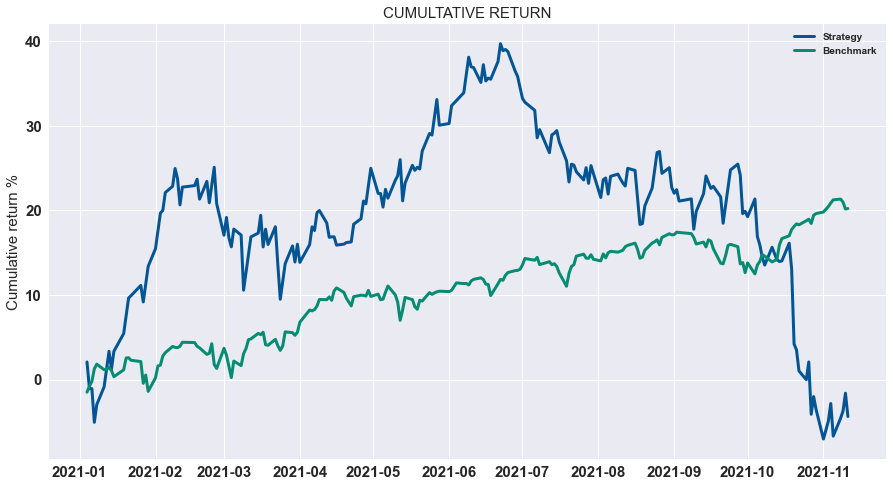

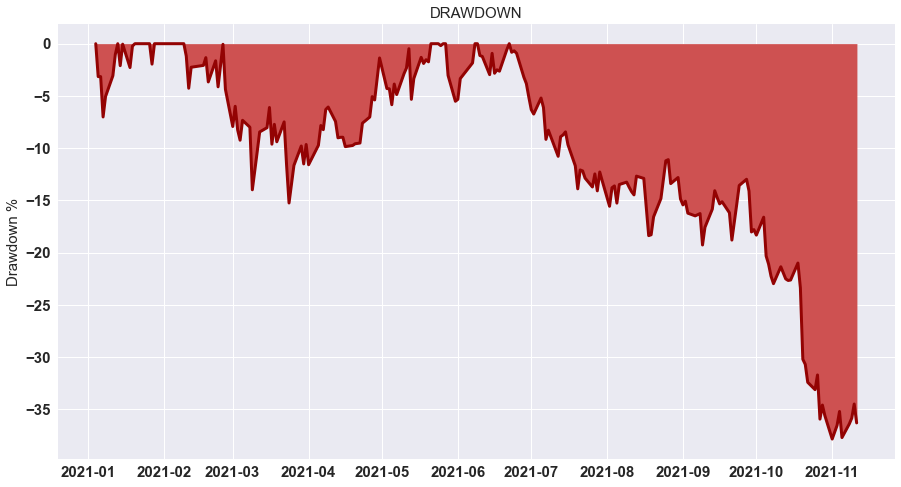

In [31]:
tp = 2.1/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)

backtest_dynamic_portfolio(pf["Return"])